TO DO:

1. Cell 35: df[:1000]

How to remove &#128514 from string?

remove everything that comes right before @ : !!!!&8220;@selfiequeenbri

# Hate Speech Classification using BERT

Our goal here is to create a model that takes a sentence (just like the ones in our dataset) and produces either 0 (indicating the sentence is identified as hate speech) or a 1 (indicating the sentence is identified as offensive language) or a 2 (indicating the sentence is identified as neither)

##Our baseline is composed of two parts:

1. DistilBERT processes the sentence and generates an embedding matrix to be used in the classifier. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
2. The classifier we use as a baseline is a basic Logistic Regression model that will take in the result of DistilBERT’s processing, and classify the sentence as either hate speech, offensive language, neither (0, 1, or 2, respectively).

The data we pass between the two models is a vector of size 768. We can think of this vector as an embedding for the sentence that we can use for classification.

In [2]:
import re
import html
import numpy as np
import pandas as pd
import torch
!pip3 install transformers
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Dataset
The dataset we will use in this example is Automated Hate Speech Detection and the Problem of Offensive Language: 24,802 labeled tweets with labels range from hate speech, offensive language, or neither. 

Source: https://data.world/thomasrdavidson/hate-speech-and-offensive-language

1. The data are stored as a CSV and as a pickled pandas dataframe (Python 2.7). Each data file contains 5 columns:

- count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

- hate_speech = number of CF users who judged the tweet to be hate speech.

- offensive_language = number of CF users who judged the tweet to be offensive.

- neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

- class = class label for majority of CF users.
0 - hate speech,
1 - offensive language,
2 - neither

In [3]:
df = pd.read_csv('labeled_data.csv', index_col=0)
df.head(25)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [4]:
#from wordsegment import load, segment # to desegment the words
def replace(text):
  text = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)', '', text, flags=re.MULTILINE)
  text = re.sub(r'[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)', '', text, flags=re.MULTILINE) # to remove other url links
  text = html.unescape(text)
  text = text.lower()
  text = re.sub(r"\’", "\'", text)
  text = re.sub(r"won\'t", "will not", text)
  text = re.sub(r"can\'t", "can not", text)
  text = re.sub(r"ain\'t", "am not", text)
  text = re.sub(r"n\'t", " not", text)
  text = re.sub(r"\'re", " are", text)
  text = re.sub(r"\'s", "", text)
  text = re.sub(r"\'d", " would", text)
  text = re.sub(r"\'ll", " will", text)
  text = re.sub(r"\'t", " not", text)
  text = re.sub(r"\'ve", " have", text)
  text = re.sub(r"\'m", " am", text)
  text = re.sub(r"(rt @[-a-zA-Z0-9@:%._\+~#=]+)|(@[-a-zA-Z0-9@:%._\+~#=]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", text)
  return text

df['clean_tweet'] = df['tweet'].apply(lambda x: replace(x))
df.head(25)

,count,hate_speech,offensive_language,neither,class,tweet,clean_tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,as a woman you should not complain about cle...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats dwn bad for cuffin dat hoe in the ...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever fuck a bitch and she start to...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,she look like a tranny
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,the shit you hear about me might be true or ...
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",the shit just blows you so faithful and down...
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ...",i can not just sit up and hate on another bit...
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,cause i am tired of you big bitches coming fo...
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ...",you might not get ya bitch back thats that
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria...",hobbies include fighting mariambitch


We take 1000 samples from the dataset for resource considerations

In [27]:
batch_1 = df[:1500]
batch_1
batch_1['class'].value_counts()

1    1189
2     237
0      74
Name: class, dtype: int64

# Loading the Pre-trained BERT model

In [28]:
# Import pre-trained DistilBERT model and tokenizer
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

# Model #1: Preparing the Dataset

## Tokenize

Here, we’ll tokenize and process all sentences together as a batch (the notebook processes a smaller group of examples just for resource considerations, let’s say 2000 examples).

In [29]:
tokenized = batch_1['clean_tweet'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True))) # This turns every sentence into the list of ids.
tokenized

0       [101, 2004, 1037, 2450, 2017, 2323, 2025, 1761...
1       [101, 2879, 23755, 2015, 1040, 7962, 2919, 200...
2       [101, 4830, 27767, 2017, 2412, 6616, 1037, 774...
3         [101, 2016, 2298, 2066, 1037, 25283, 4890, 102]
4       [101, 1996, 4485, 2017, 2963, 2055, 2033, 2453...
                              ...                        
1526    [101, 1045, 2572, 9303, 2050, 4521, 2070, 2241...
1527    [101, 2043, 3057, 2202, 2026, 10245, 10457, 19...
1528    [101, 1037, 2047, 8843, 1997, 2317, 2611, 2016...
1529    [101, 1037, 7743, 2071, 2025, 3477, 2033, 2000...
1530    [101, 9152, 23033, 2015, 2215, 22418, 1045, 25...
Name: clean_tweet, Length: 1500, dtype: object

## Padding

Before DistilBERT can process this as input, we’ll need to make all the vectors the same size by padding shorter sentences with the token id 0.


After tokenization, tokenized is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [30]:
max_len = max(tokenized.apply(len))
print(max_len)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(padded).shape

47


(1500, 47)

## Masking
If we directly send padded to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:

In [31]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(1500, 47)

# Model #1: Deep Learning

The model() function runs our sentences through BERT. The results of the processing will be returned into last_hidden_states.

In [32]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
  last_hidden_states = model(input_ids, attention_mask=attention_mask)[0][:,0,:].numpy()

Then, we slice only the part of the output that we need, which is the output corresponding the first token of each sentence

In [33]:
features = last_hidden_states

In [34]:
labels = batch_1['class']

# Model #2: Train/Test Split

In [35]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2)
dev_features, test_features, dev_labels, test_labels = train_test_split(test_features, test_labels, test_size=0.5)
print(train_features.shape, dev_features.shape, test_features.shape)

(1200, 768) (150, 768) (150, 768)


In [36]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
test_predict = lr_clf.predict(test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [37]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
print('f1 score is', f1_score(test_predict, test_labels, average='micro'))
roc_auc_score(test_predict, lr_clf.predict_proba(test_features), multi_class='ovr')

f1 score is 0.8333333333333334


1.0

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
cm = metrics.confusion_matrix(test_predict, test_labels)
print(cm)

[[  2   0   2]
 [  6 108   9]
 [  3   5  15]]


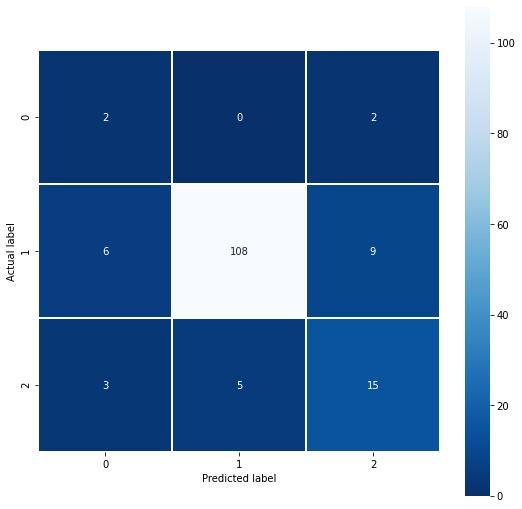

In [39]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');